In the first step the data set is created in a pandas Dataframe (load_data)
the missing values are infered from the description using an LLM endpoint, the values with empty critical cells are pruned and the description column erased since is no longer useful.
next the DataFframe is prinned for the id and gender wich the first is irrelevant , and the second has an extremely low correlation with salary and the other features.
the dataset is divided in two , features and target (x and y), and again in to an 80/20 split for training and testing resplectibly.
the jobtitle are modeled with a target encoder based on job title grouping and the salaries, to avoid implicit relationships that are not representative of the data by modeling the feature in a "naive" aproach for example order of aparition.
after that a normalization step is done to properly scale the data for the Random Forest Reggressor.


2025-01-13 02:16:26.029696: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
/home/haervwe/Predictive_Models/salary_predictive_model/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
DEBUG:src.llm_dataset_filler:Tota


Full Merged Dataset:
   id   Age  Gender Education Level          Job Title  Years of Experience  \
0   0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1   1  28.0  Female        Master's       Data Analyst                  3.0   
2   2  45.0    Male             PhD     Senior Manager                 15.0   
3   3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4   4  52.0    Male        Master's           Director                 20.0   

                                         Description    Salary  
0  I am a 32-year-old male working as a Software ...   90000.0  
1  I am a 28-year-old data analyst with a Master'...   65000.0  
2  I am a 45-year-old Senior Manager with a PhD a...  150000.0  
3  I am a 36-year-old female Sales Associate with...   60000.0  
4  I am a 52-year-old male with over two decades ...  200000.0  
      id   Age  Gender Education Level                      Job Title  \
370  370  35.0  Female      Bachelor's  

DEBUG:src.llm_dataset_filler:Index 260: Received NDJSON response for Years of Experience.
DEBUG:src.llm_dataset_filler:Index 172: Received NDJSON response for Salary.
DEBUG:src.llm_dataset_filler:Index 315: Received NDJSON response for Age.
DEBUG:src.llm_dataset_filler:Index 260: Received NDJSON response for Age.
DEBUG:src.llm_dataset_filler:Index 260: Inferred Years of Experience: Not found
DEBUG:src.llm_dataset_filler:Index 172: Inferred Salary: Not found
DEBUG:src.llm_dataset_filler:Index 315: Inferred Age: Not found
DEBUG:src.llm_dataset_filler:Index 260: Inferred Age: Not found
DEBUG:src.llm_dataset_filler:Index 60: Received NDJSON response for Job Title.
DEBUG:src.llm_dataset_filler:Index 172: Received NDJSON response for Gender.
DEBUG:src.llm_dataset_filler:Index 172: Received NDJSON response for Age.
DEBUG:src.llm_dataset_filler:Index 172: Received NDJSON response for Job Title.
DEBUG:src.llm_dataset_filler:Index 172: Inferred Gender: Not found
DEBUG:src.llm_dataset_filler:Inde


Missing Values in Full Dataset:
id                     0
Age                    3
Gender                 3
Education Level        2
Job Title              2
Years of Experience    2
Description            3
Salary                 2
dtype: int64

Rows with Missing Values:
      id   Age Gender Education Level                    Job Title  \
111  111  37.0   Male      Bachelor's     Software Project Manager   
125  125  26.0   Male      Bachelor's            Junior Accountant   
172  172   NaN    NaN             NaN                          NaN   
177  177  31.0   Male      Bachelor's            Junior Accountant   
219  219  40.0    NaN      Bachelor's  Senior Sales Representative   
260  260   NaN    NaN             NaN                          NaN   
315  315   NaN   Male      Bachelor's     Senior Software Engineer   

     Years of Experience                                        Description  \
111                  9.0                                                NaN   
125     

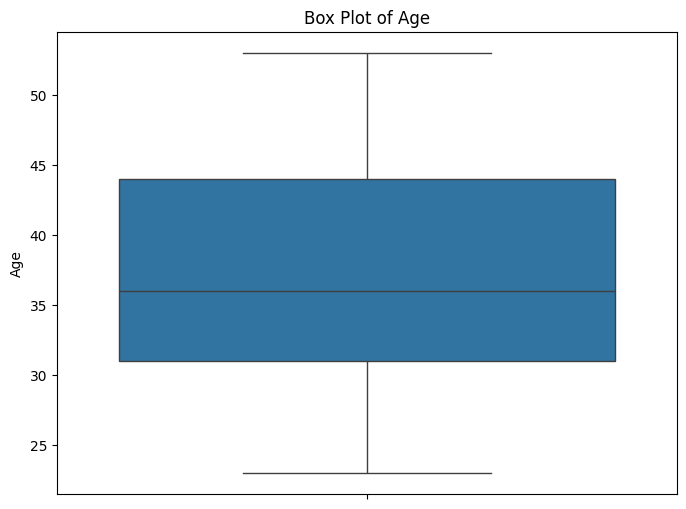

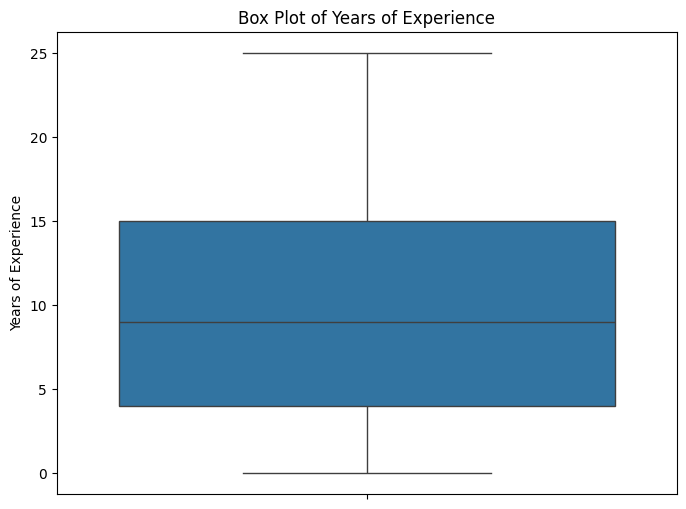

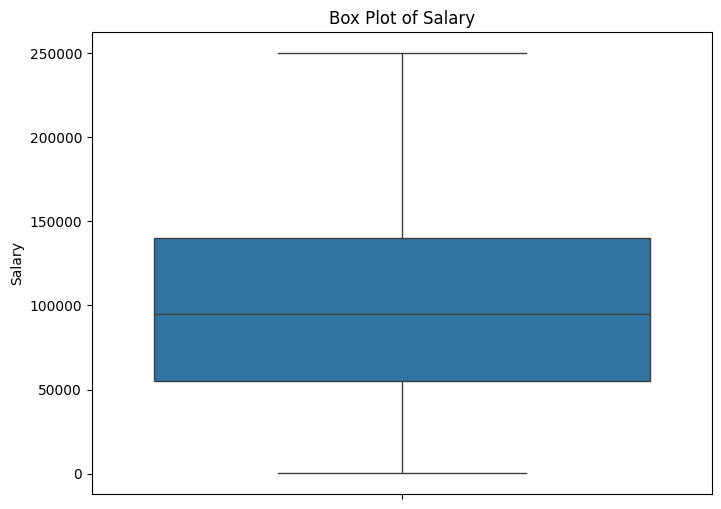

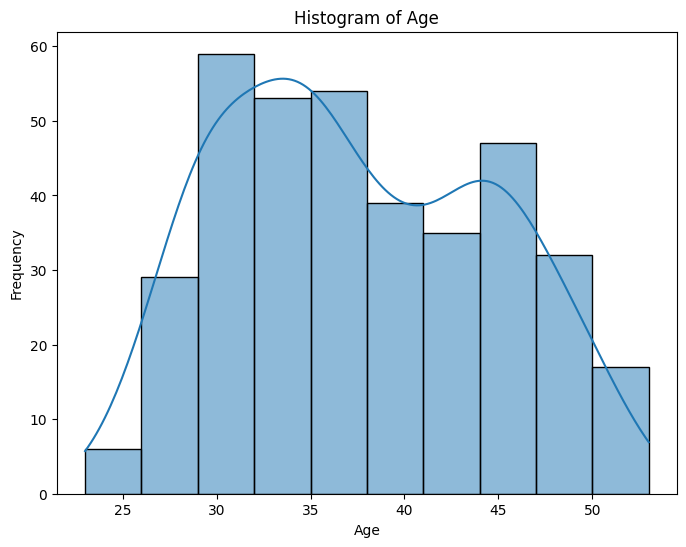

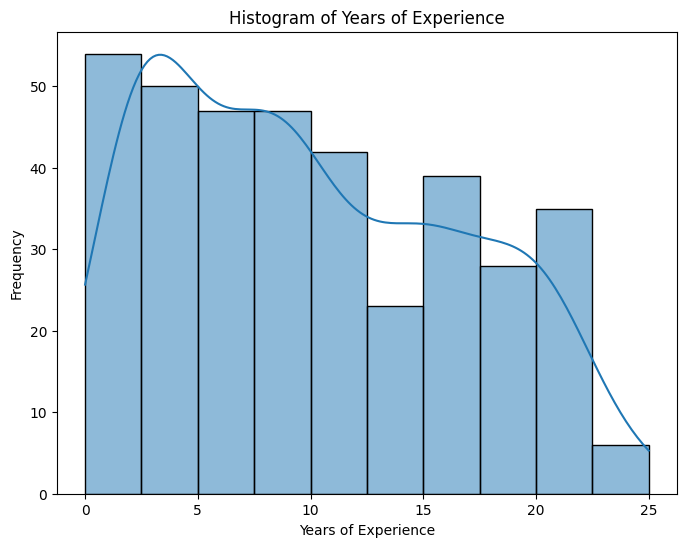

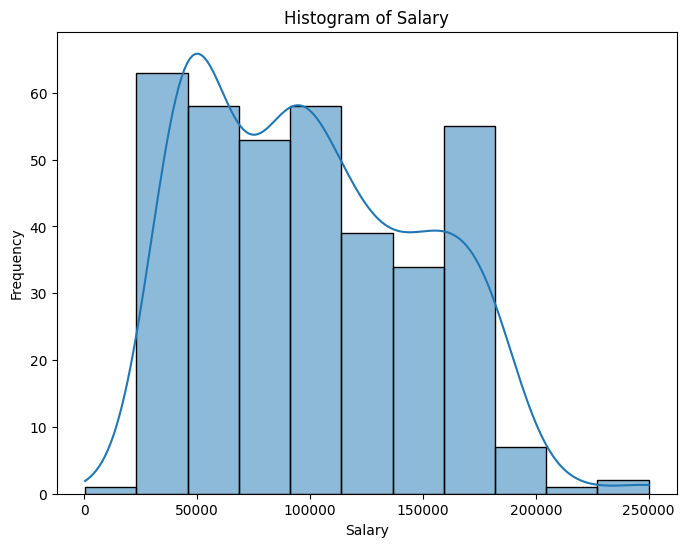

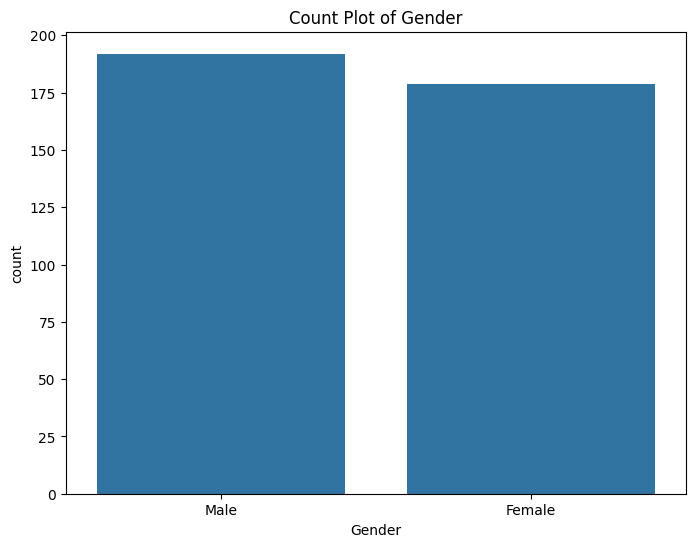

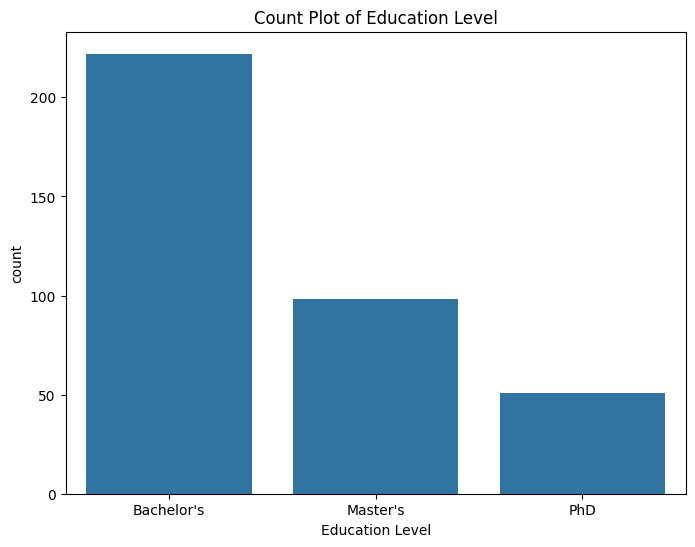

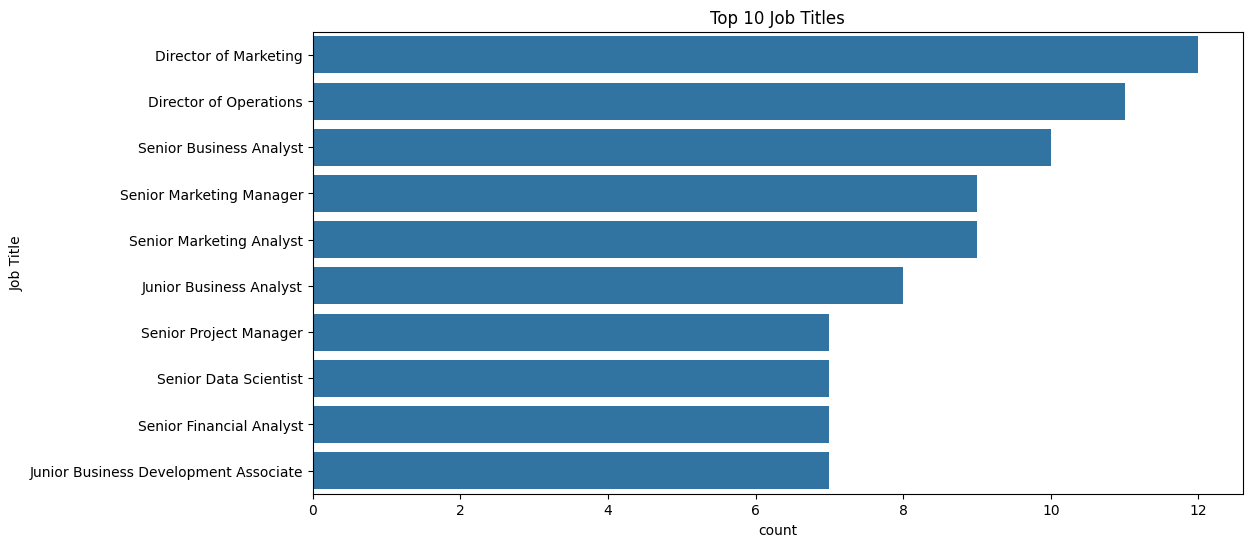

In [1]:
import matplotlib.font_manager as fm
import logging

fm._log.setLevel(logging.WARNING)  

from src import data_loading
from src import preprocessing
from src import visualize_data
from src import feature_engenieering
from src import modeling
from src import evaluation




#files path for the raw dataset:
data_files = ['./data/people.csv','./data/descriptions.csv','./data/salary.csv',]

#merge datasets in a cohesive Dataframe
full_dataset = data_loading.load_data(data_files)

#preprocessing of the dataframe adds missing values with LLM inference over descriptions of each row, drops the incomplete rows and cleans up the data.
cleansed_dataset = await preprocessing.preprocess(full_dataset)

visualize_data.visualize_dataset(cleansed_dataset)

#split the dataset into an 80 / 20 ratio for training and testing.
X_train, X_test, y_train, y_test = feature_engenieering.split_data(cleansed_dataset)


#normalize and scale the datasets using MinMaxScaler and target encoder

normalized_X_train, te, scaler = feature_engenieering.normalize_train_data(X_train, y_train)

normalized_X_test = feature_engenieering.normalize_test_data(X_test, te, scaler)




With the datasets created we use the train dataset splits in a script to create a Random Forest Regressor using the scikit-learn framework.

In [2]:
#train the model using a random forest regressor algorithm and print out the predictions for the normalized test data.

model = modeling.train_model(normalized_X_train, y_train)




Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_e

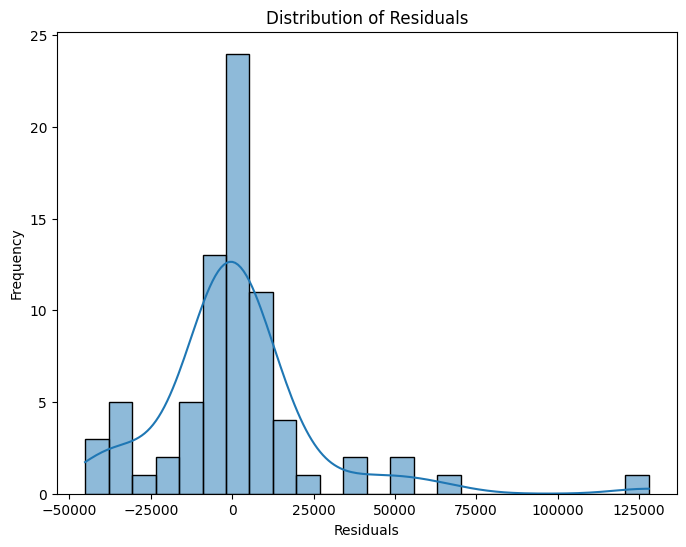

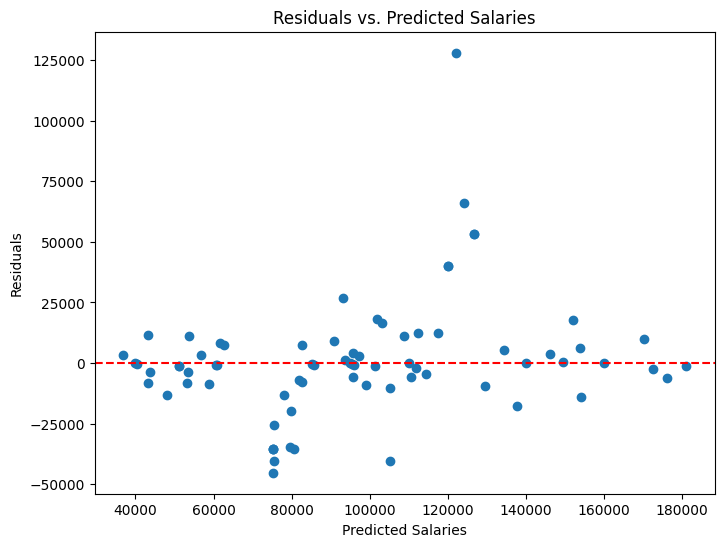

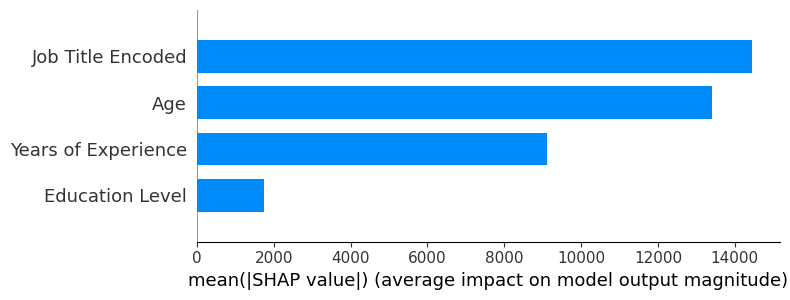

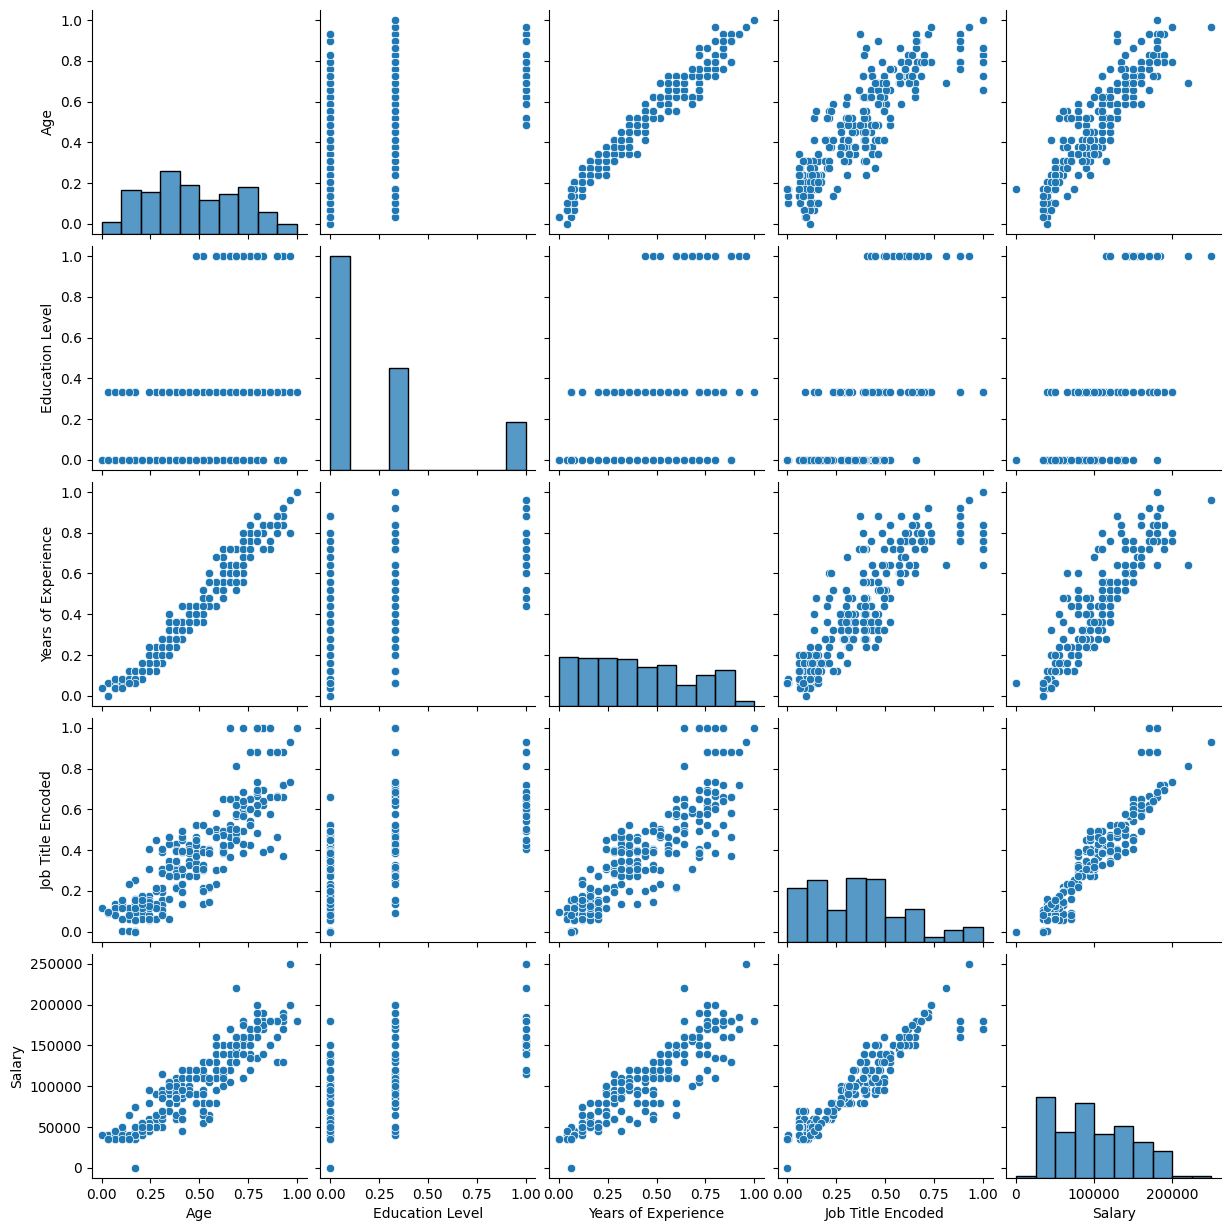

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x761480ee8380>


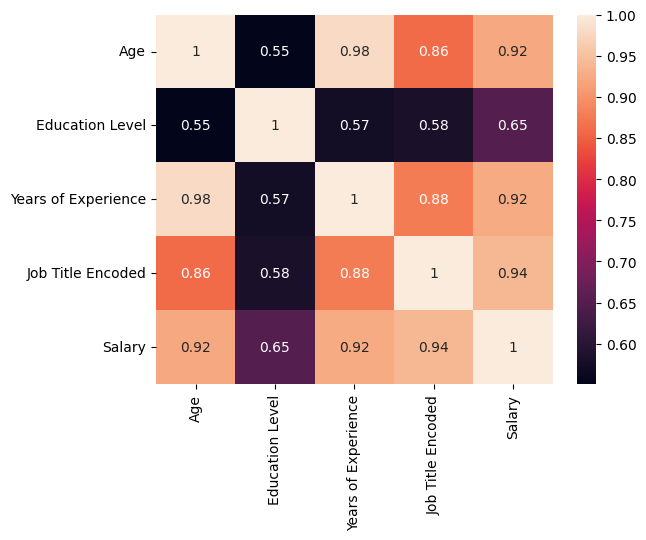

Random Forest Regressor Performance After Hyperparameter Tuning:
Mean Squared Error (MSE): 621170022.45
Mean Absolute Error (MAE): 14778.90
R-squared Score (R²): 0.74


In [3]:
#use the test dataset to predict salaries based on the trained model for a first fast evaluation.

evaluation.evaluate_model(normalized_X_test, y_test, normalized_X_train,y_train, model)

In [4]:
evaluation.calculate_metrics(normalized_X_test, y_test, model)

Random Forest Regressor Performance with Confidence Intervals:
Mean Squared Error (MSE): 614535752.01 (95% CI: [306350570.88, 1042534095.11])
Mean Absolute Error (MAE): 14729.20 (95% CI: [11163.07, 18649.42])
R-squared Score (R²): 0.75 (95% CI: [0.61, 0.86])


I choose the Random Forest Reggresor to be able to catch non linear relationships better with realtively low data quantity for training, the model is Hyperparametrized using a grid approach and the best model is selected for testing.

In the process of selecting features for the Random Forest Regressor model, based on correlation and feature importance analysis after the first "naive" model was trained in the normalized data as is to gather more information on the relationships and model error R-squared Score (R²).

it is also quite notable that the heteroscedasticity present in the middle of the distribution seems to be caused by the dataset itself, most possibly by the lack of examples to fill the distribution appropiately, otherwise the distribution of residuals seems to be acceptable.

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 866064920.96
        Mean Absolute Error (MAE): 17982.33
        R-squared Score (R²): 0.65
        
![img](./plots/residuals_distribution.png)
![Feature Importance](./plots/feature_importance.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap.png)



It can be seen now better results by droping geneder since it has a really low correlation with salary and importance , and lower the smoothing for the encoded job titles to 3 (10 was the previous value).

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 600148032.12
        Mean Absolute Error (MAE): 14748.68
        R-squared Score (R²): 0.76

![img](./plots/residuals_distribution_2.png)
![Feature Importance](./plots/feature_importance_2.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap_2.png)

        
next feature to remove, surprinsingly is education level wich has a low correlation with salary, but if pruned from the dataset the model shows performs worst than before with the same hyperparametrization.

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 808374516.33
        Mean Absolute Error (MAE): 17240.95
        R-squared Score (R²): 0.67

![img](./plots/residuals_distribution_3.png)
![Feature Importance](./plots/feature_importance_3.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap_3.png)

